In [ ]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, r2_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import parallel_backend
import numpy as np
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
import os
import matplotlib.pyplot as plt

from tqdm  import tqdm

os.getcwd()

'/workspaces/muldistribution/models'

# データ読み込みと前処理
この処理で、それぞれいろんな形式を持つデータを統合。全国各1kmグリッドに対して診療科別POI件数、人口、セントロイド座標を付与し、geopackageとcsvで出力している。(geopackageいるかな？)

In [ ]:
"""
全国 1 km グリッドに
  ① 診療科別 POI 件数
  ② 人口
  ③ セントロイド座標（メートル系）
を付与し、GeoPackage と CSV を出力するユーティリティ。
"""

from pathlib import Path
import geopandas as gpd

# ───────── 0. パス定義 ────────────────────────────────
DATA_DIR   = Path("../data")
GRID_PATH  = DATA_DIR / "grid/wholejapan_grid/wholejapan_grid.shp"
POP_PATH   = DATA_DIR / "pop/2010/pop_grid.gpkg"
POI_DIR    = DATA_DIR / "medicalpoi/2010"

OUTPUT_GPKG = Path("grid_features.gpkg")
OUTPUT_CSV  = Path("grid_features.csv")

POI_FILES = {
    "Rehab" : POI_DIR / "リハビリテーション科.shp",
    "Gastro": POI_DIR / "消化器内科.shp",
    "Cardio": POI_DIR / "循環器内科.shp",
    "Uro"   : POI_DIR / "泌尿器内科.shp",
}

POP_COL   = "Total population"   # pop_grid.gpkg 内の列名
GRID_ID   = "grid_id"            # 無ければ自動生成
TARGET_EPSG = 6697               # JGD2011 / Albers（メートル系）

# ───────── 1. ヘルパー関数群 ─────────────────────────
def read_layer(path: Path, crs_like) -> gpd.GeoDataFrame:
    """CRS を揃えて読み込む（Undefined → crs_like をセット）"""
    gdf = gpd.read_file(path)
    if gdf.crs is None:
        gdf = gdf.set_crs(crs_like)
    return gdf.to_crs(crs_like)

def attach_poi_counts(grid: gpd.GeoDataFrame,
                      poi_path: Path,
                      out_col: str) -> gpd.GeoDataFrame:
    """POI シェープを読み込み、グリッド内件数を付与"""
    poi   = read_layer(poi_path, grid.crs)
    cnt   = (
        gpd.sjoin(poi[['geometry']], grid[[GRID_ID, 'geometry']],
                  predicate='within', how='left')
        .groupby(GRID_ID).size().rename(out_col)
    )
    grid  = grid.join(cnt, on=GRID_ID)
    grid[out_col] = grid[out_col].fillna(0).astype('uint16')
    return grid

# ───────── 2. グリッド GDF 準備 ──────────────────────
grid = read_layer(GRID_PATH, 4326)
if GRID_ID not in grid.columns:
    grid[GRID_ID] = grid.index.astype(int)

# ───────── 3. 診療科 POI 件数の付与 ──────────────────
for short, shp in POI_FILES.items():
    grid = attach_poi_counts(grid, shp, f"{short}_cnt")

# ───────── 4. 人口メッシュ集計（intersects 合計） ─────
pop = read_layer(POP_PATH, grid.crs)[[POP_COL, 'geometry']]
pop_sum = (
    gpd.sjoin(pop, grid[[GRID_ID, 'geometry']],
              predicate='intersects', how='left')
    .groupby(GRID_ID)[POP_COL].sum()
    .rename("population")
)
grid = grid.join(pop_sum, on=GRID_ID)
grid["population"] = grid["population"].fillna(0).astype('uint32')

# ───────── 5. セントロイド XY（メートル系） ──────────
grid_proj = grid.to_crs(TARGET_EPSG)
cent = grid_proj.geometry.centroid 
grid["centroid_X"] = cent.x
grid["centroid_Y"] = cent.y

# ───────── 6. 出力 ────────────────────────────────
grid.to_file(OUTPUT_GPKG, layer="features", driver="GPKG", overwrite=True)
grid.drop(columns='geometry').to_csv(OUTPUT_CSV, index=False)

print("✅ Saved:", OUTPUT_GPKG, "and", OUTPUT_CSV)

/tmp/ipykernel_13647/2019693237.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cent = grid.to_crs(TARGET_EPSG).geometry.centroid


✅ Saved: grid_features.gpkg and grid_features.csv


In [7]:
grid.head()

,KEY_CODE,MESH1_ID,MESH2_ID,MESH3_ID,OBJ_ID,geometry,grid_id,Rehab_cnt,Gastro_cnt,Cardio_cnt,Uro_cnt,population,centroid_X,centroid_Y
0,66440000,6644,00,00,1.0,"POLYGON ((144.0125 44, 144 44, 144 44.00833, 1...",0,0,0,0,0,4,144.00625,44.004167
1,66440001,6644,00,01,2.0,"POLYGON ((144.025 44, 144.0125 44, 144.0125 44...",1,0,0,0,0,0,144.01875,44.004167
2,66440002,6644,00,02,3.0,"POLYGON ((144.0375 44, 144.025 44, 144.025 44....",2,0,0,0,0,0,144.03125,44.004167
3,66440003,6644,00,03,4.0,"POLYGON ((144.05 44, 144.0375 44, 144.0375 44....",3,0,0,0,0,0,144.04375,44.004167
4,66440004,6644,00,04,5.0,"POLYGON ((144.0625 44, 144.05 44, 144.05 44.00...",4,0,0,0,0,0,144.05625,44.004167


# 各診療科の相関だけみとく。

In [8]:
cols = ["Rehab_cnt", "Gastro_cnt", "Cardio_cnt", "Uro_cnt"]
corr = grid[cols].corr(method="spearman")   # カウントは歪みが大きいので rank 相関が無難
print(corr.round(3))

            Rehab_cnt  Gastro_cnt  Cardio_cnt  Uro_cnt
Rehab_cnt       1.000       0.638       0.600    0.501
Gastro_cnt      0.638       1.000       0.705    0.484
Cardio_cnt      0.600       0.705       1.000    0.491
Uro_cnt         0.501       0.484       0.491    1.000


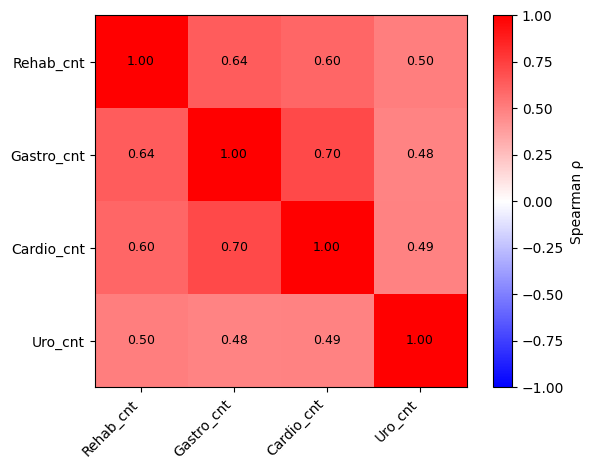

In [11]:
fig, ax = plt.subplots()

im = ax.imshow(corr, vmin=-1, vmax=1, cmap="bwr")

# 軸ラベル
ax.set_xticks(np.arange(len(cols)))
ax.set_yticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45, ha="right")
ax.set_yticklabels(cols)

# 値を描き込む
for i in range(len(cols)):
    for j in range(len(cols)):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                ha="center", va="center", color="black", fontsize=9)

fig.colorbar(im, ax=ax, label="Spearman ρ")
plt.tight_layout()
plt.show()

→結構相関高いね、まとめてモデル回したほうがいいんじゃない？

# random forest の構築

In [ ]:
# rf_gridsearch_by_section.py

# ── 0.  入力ファイル ────────────────────────────────
df_path = Path("ml_table.csv")          # 作成済み CSV
df = pd.read_csv(df_path)

# ── 1.  共通設定 ──────────────────────────────────
features = ["population", "centroid_X", "centroid_Y"]
targets  = {
    "Rehabilitation_cnt": "Rehabilitation",
    "Gastro_cnt":         "Gastroenterology",
    "Cardio_cnt":         "Cardiology",
    "Urology_cnt":        "Urology (Med.)"
}
test_size    = 0.2
random_state = 42
cv_folds     = 5

# RMSE（正の値）を返す scorer
rmse_scorer = make_scorer(
    lambda y, yhat: np.sqrt(mean_squared_error(y, yhat)),
    greater_is_better=False       # GridSearch は「大きいほど良い」を期待
)

# 代表的なハイパーパラメータセット
param_grid = {
    "n_estimators":      [200, 400, 800],
    "max_depth":         [None, 15, 30, 60],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":      ["sqrt", "log2", 0.6]   # 0.6 = 全特徴量の60%
}

print(f"─ Grid search: {len(param_grid['n_estimators'])*len(param_grid['max_depth'])*len(param_grid['min_samples_split'])*len(param_grid['min_samples_leaf'])*len(param_grid['max_features'])} parameter combos × {cv_folds}-fold CV\n")

# ── 2.  診療科ごとに学習 ───────────────────────────
for col, label in tqdm(targets.items()):
    X = df[features]
    y = df[col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    base_rf = RandomForestRegressor(random_state=random_state)

    gsearch = GridSearchCV(
        base_rf,
        param_grid,
        scoring={"RMSE": rmse_scorer, "R2": "r2"},
        refit="RMSE",         # = 最小 RMSE を選ぶ
        cv=cv_folds,
        n_jobs=-1,            # CPU 全コア
        verbose=0
    )

    # scikit‑learn 1.4 以降は loky backend がデフォルト
    with parallel_backend("loky"):
        gsearch.fit(X_train, y_train)

    best = gsearch.best_estimator_
    y_pred = best.predict(X_test)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test   = r2_score(y_test, y_pred)

    print(f"{label:20s} |  RMSE_test = {rmse_test:7.3f}   R²_test = {r2_test:6.3f}")
    print("   best_params :", gsearch.best_params_, "\n")

─ Grid search: 324 parameter combos × 5-fold CV



  0%|          | 0/4 [00:00<?, ?it/s]/Users/tomokitakata/Desktop/research/dev/muldistribution/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)
/Users/tomokitakata/Desktop/research/dev/muldistribution/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
  0%|          | 0/4 [3:55:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def train_per_department(df, input_columns, target_columns, model_class=RandomForestRegressor, model_params=None):
    results = {}
    for col in tqdm(target_columns):
        print(f"\n==== 🏥 {col} の学習開始 ====")
        X = df[input_columns]
        y = df[col]

        # 欠損除去
        data = pd.concat([X, y], axis=1).fillna(0)
        X = data[input_columns]
        y = data[col]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = model_class(**(model_params or {}))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"  RMSE: {rmse:.3f}, R²: {r2:.3f}")

        results[col] = {
            "model": model,
            "rmse": rmse,
            "r2": r2
        }
    return results

In [17]:
input_cols = ["population"]
target_cols = ["inner_med_grid"]

results = train_per_department(
    df=mesh_df,
    input_columns=input_cols,
    target_columns=target_cols,
    model_class=RandomForestRegressor,
    model_params={"n_estimators": 100}
)


==== 🏥 inner_med_grid の学習開始 ====
  RMSE: 0.413, R²: 0.462


In [34]:
def evaluate_models(df, input_columns, target_column,
                    rf_params=None, xgb_params=None, lgbm_params=None,
                    test_size=0.2, random_state=42):
    # 入力と出力
    X = df[input_columns].fillna(0)
    y = df[target_column].fillna(0)

    # データ分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # yが2次元(n_samples, 1)になっちゃうので、1次元(n_samples,)に変換
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # モデルとパラメータ
    models = {
        "RandomForest": RandomForestRegressor(random_state=random_state, **(rf_params or {})),
        "XGBoost": XGBRegressor(random_state=random_state, verbosity=0, **(xgb_params or {})),
        "LightGBM": LGBMRegressor(random_state=random_state, **(lgbm_params or {}))
    }

    results = {}
    records = []



    # 各モデルの学習・予測・評価
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            "model": model,
            "rmse": rmse,
            "r2": r2
        }
        records.append({
            "model": name,
            "rmse": rmse,
            "r2": r2
        })

        print(f"[{name}] RMSE: {rmse:.3f}, R²: {r2:.3f}")

    # 結果をDataFrame化
    result_df = pd.DataFrame(records)

    # RMSEが最小のモデルを明示的に選ぶ（sortを使わない）
    min_rmse = result_df["rmse"].min()
    best_model_row = result_df[result_df["rmse"] == min_rmse].iloc[0]
    best_model_name = best_model_row["model"]

    print(f"best model：{best_model_name}（min RMSE: {min_rmse:.3f}）")

    # 表示・見やすさのために結果をrmse順に並び替えて返す
    result_df = result_df.sort_values("rmse").reset_index(drop=True)


    return results, result_df

In [33]:
results, result_df = evaluate_models(
    df=mesh_df,
    input_columns=["population"],
    target_column=["inner_med_grid"],
    rf_params={"n_estimators": 100},
    xgb_params={"n_estimators": 100, "learning_rate": 0.1},
    lgbm_params={"n_estimators": 100, "learning_rate": 0.1}
)

result_df

 33%|███▎      | 1/3 [00:06<00:13,  6.95s/it]

[RandomForest] RMSE: 0.415, R²: 0.461


 67%|██████▋   | 2/3 [00:07<00:03,  3.00s/it]

[XGBoost] RMSE: 0.311, R²: 0.595
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 401200, number of used features: 1
[LightGBM] [Info] Start training from score 0.118053


100%|██████████| 3/3 [00:07<00:00,  2.59s/it]

[LightGBM] RMSE: 0.303, R²: 0.606
best model：LightGBM（min RMSE: 0.303）


,model,rmse,r2
0,LightGBM,0.303173,0.605643
1,XGBoost,0.311187,0.595220
2,RandomForest,0.414521,0.460806


In [31]:
result_df.head()

,model,rmse,r2
0,LightGBM,0.303173,0.605643
1,XGBoost,0.311187,0.595220
2,RandomForest,0.414521,0.460806


In [35]:
from itertools import product

def generate_param_grid(param_options):
    keys, values = zip(*param_options.items())
    return [dict(zip(keys, v)) for v in product(*values)]

In [39]:
import time
import pandas as pd

def run_sequential_experiments_with_time_tqdm(df, input_columns, target_column,
                                              rf_grid, xgb_grid, lgbm_grid):
    all_results = []

    rf_combos = generate_param_grid(rf_grid)
    xgb_combos = generate_param_grid(xgb_grid)
    lgbm_combos = generate_param_grid(lgbm_grid)

    total_runs = len(rf_combos) + len(xgb_combos) + len(lgbm_combos)
    pbar = tqdm(total=total_runs, desc="Running experiments")

    for rf_params in rf_combos:
        start = time.time()
        results, df_result = evaluate_models(df, input_columns, target_column, rf_params=rf_params)
        duration = time.time() - start
        df_result["params"] = str(rf_params)
        df_result["model_type"] = "RandomForest"
        df_result["time_sec"] = duration
        all_results.append(df_result)
        pbar.update(1)

    for xgb_params in xgb_combos:
        start = time.time()
        results, df_result = evaluate_models(df, input_columns, target_column, xgb_params=xgb_params)
        duration = time.time() - start
        df_result["params"] = str(xgb_params)
        df_result["model_type"] = "XGBoost"
        df_result["time_sec"] = duration
        all_results.append(df_result)
        pbar.update(1)

    for lgbm_params in lgbm_combos:
        start = time.time()
        results, df_result = evaluate_models(df, input_columns, target_column, lgbm_params=lgbm_params)
        duration = time.time() - start
        df_result["params"] = str(lgbm_params)
        df_result["model_type"] = "LightGBM"
        df_result["time_sec"] = duration
        all_results.append(df_result)
        pbar.update(1)

    pbar.close()
    final_df = pd.concat(all_results, ignore_index=True)
    return final_df

In [45]:
rf_param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [5, 10, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3]
}

xgb_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.1, 0.3],
    "max_depth": [3, 6],
    "min_child_weight": [1, 5],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

lgbm_param_grid = {
    "n_estimators": [50, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [5, 10, -1],
    "num_leaves": [15, 31, 63],
    "min_child_samples": [10, 20],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0]
}

# 実行
experiment_results = run_sequential_experiments_with_time_tqdm(
    df=mesh_df,
    input_columns=["population"],
    target_column="inner_med_grid",
    rf_grid=rf_param_grid,
    xgb_grid=xgb_param_grid,
    lgbm_grid=lgbm_param_grid
)

# 上位結果を確認
print(experiment_results.sort_values("rmse").head())

KeyboardInterrupt: 

In [44]:
experiment_results.sort_values("rmse")

,model,rmse,r2,params,model_type,time_sec
0,RandomForest,0.301596,0.607695,"{'n_estimators': 50, 'max_depth': 5}",RandomForest,3.060278
6,RandomForest,0.301738,0.607511,"{'n_estimators': 100, 'max_depth': 5}",RandomForest,5.166987
36,LightGBM,0.303133,0.605696,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",LightGBM,7.766892
1,LightGBM,0.303173,0.605643,"{'n_estimators': 50, 'max_depth': 5}",RandomForest,3.060278
3,LightGBM,0.303173,0.605643,"{'n_estimators': 50, 'max_depth': 10}",RandomForest,3.828346
7,LightGBM,0.303173,0.605643,"{'n_estimators': 100, 'max_depth': 5}",RandomForest,5.166987
9,LightGBM,0.303173,0.605643,"{'n_estimators': 100, 'max_depth': 10}",RandomForest,6.970121
15,LightGBM,0.303173,0.605643,"{'n_estimators': 50, 'learning_rate': 0.3, 'ma...",XGBoost,7.800660
12,LightGBM,0.303173,0.605643,"{'n_estimators': 50, 'learning_rate': 0.1, 'ma...",XGBoost,7.716852
39,LightGBM,0.303175,0.605641,"{'n_estimators': 100, 'learning_rate': 0.1, 'm...",LightGBM,7.977079
